# NYC Yellow Taxi – Data Exploration

This notebook provides a basic exploration of the NYC Yellow Taxi dataset for January 2023. The goal is to understand the structure and distribution of key variables before moving on to transformation and modeling.

In [102]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from pathlib import Path

# Set global float display format to two decimal places with commas
pd.options.display.float_format = '{:.2f}'.format

In [103]:
# Get the root of the project (automatically resolves relative to this script)
PROJECT_ROOT = Path().resolve().parent

# Define data paths
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "yellow_tripdata_2023-01.parquet"

# Read data
df = pd.read_parquet(RAW_DATA_PATH)

In [104]:
# Check the size of the dataset
df.shape

(3066766, 19)

In [105]:
# Check the first five rows
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.00,0.97,1.00,N,161,141,2,9.30,1.00,0.50,0.00,0.00,1.00,14.30,2.50,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.00,1.10,1.00,N,43,237,1,7.90,1.00,0.50,4.00,0.00,1.00,16.90,2.50,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.00,2.51,1.00,N,48,238,1,14.90,1.00,0.50,15.00,0.00,1.00,34.90,2.50,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.00,1.90,1.00,N,138,7,1,12.10,7.25,0.50,0.00,0.00,1.00,20.85,0.00,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.00,1.43,1.00,N,107,79,1,11.40,1.00,0.50,3.28,0.00,1.00,19.68,2.50,0.00


In [106]:
# Check column data types
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

### Filter to January 2023

Some rows have pickup timestamps outside the expected date range (e.g., 2008 or 2022), likely due to data entry errors. To keep the analysis focused, we only include trips from January 1 to January 31, 2023.

In [108]:
# Filter to only include trips in January 2023
df = df[
    (df["tpep_pickup_datetime"] >= "2023-01-01") &
    (df["tpep_pickup_datetime"] < "2023-02-01")
].copy()

### Missing Values

After filtering to trips within January 2023, the proportion of missing data drops to under 2%. Most missing values appear in fields like `airport_fee` or `congestion_surcharge`, which are likely to be structurally missing — i.e., not applicable to every trip rather than true data errors. No further imputation is applied at this stage.

In [110]:
# Check the percentage of missing values (top 10)
df.isnull().mean().sort_values(ascending=False).head(10)

airport_fee             0.02
congestion_surcharge    0.02
passenger_count         0.02
RatecodeID              0.02
store_and_fwd_flag      0.02
extra                   0.00
total_amount            0.00
improvement_surcharge   0.00
tolls_amount            0.00
tip_amount              0.00
dtype: float64

In [111]:
# Helper to apply plain number formatting
def format_axis(ax):
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

### Passenger Count

This shows how many passengers were recorded per trip. Values like 0 or unusually high counts may indicate errors or special cases.

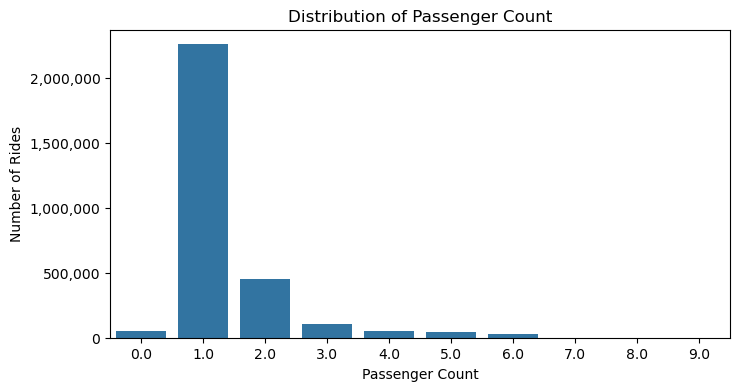

In [113]:
# Distribution of passenger count
plt.figure(figsize=(8, 4))
ax = sns.countplot(x="passenger_count", data=df)
format_axis(ax)
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Number of Rides")
plt.show()

In [114]:
# Inspect distribution percentiles
df["trip_distance"].describe(percentiles=[0.90, 0.95, 0.99])

count   3066718.00
mean          3.85
std         249.59
min           0.00
50%           1.80
90%           8.63
95%          14.32
99%          20.06
max      258928.15
Name: trip_distance, dtype: float64

### Trip Distance (Filtered < 30 miles)

Trips over 30 miles are rare and may include outliers or edge cases. For readability, the plot focuses on trips under 30 miles, which covers over 99% of the data.

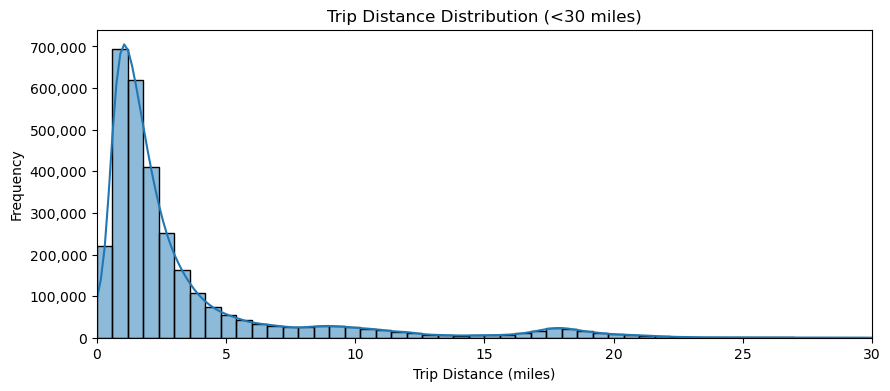

In [116]:
# Remove outliers for better visualization
df_filtered = df[df["trip_distance"] < 30]

plt.figure(figsize=(10, 4))
ax = sns.histplot(df_filtered["trip_distance"], bins=50, kde=True)
format_axis(ax)
plt.title("Trip Distance Distribution (<30 miles)")
plt.xlim(0, 30)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

### Payment Method

Visualizing payment types helps identify the most common transaction modes, as well as less frequent categories like disputes or voided charges.

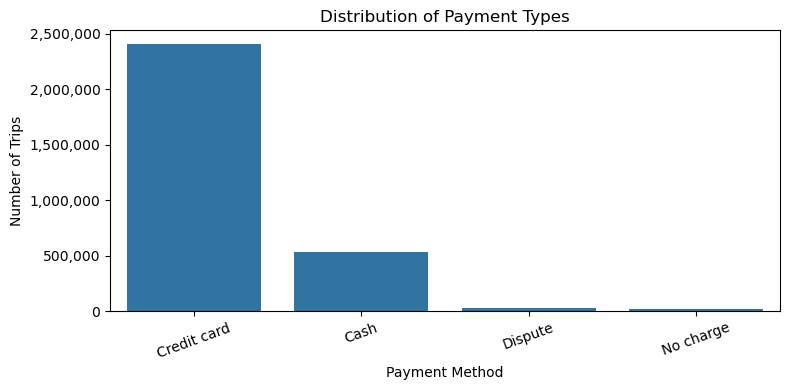

In [118]:
# Payment type frequency
# Define mapping frequency
payment_map = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

# Create a new column with readable labels
df["payment_type_label"] = df["payment_type"].map(payment_map)

# Plot using the new column
plt.figure(figsize=(8, 4))
ax = sns.countplot(x="payment_type_label", data=df, order=df["payment_type_label"].value_counts().index)
format_axis(ax)
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Method")
plt.ylabel("Number of Trips")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [119]:
# Trip duration in minutes
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [120]:
# Inspect distribution percentiles
df["trip_duration_min"].describe(percentiles=[0.90, 0.95, 0.99])

count   3066718.00
mean         15.67
std          42.59
min         -29.20
50%          11.52
90%          27.94
95%          36.47
99%          57.25
max       10029.18
Name: trip_duration_min, dtype: float64

### Trip Duration (Filtered < 3 hours)

A small number of records show unusually long durations. This plot limits the range to trips under 180 minutes to highlight typical ride lengths.

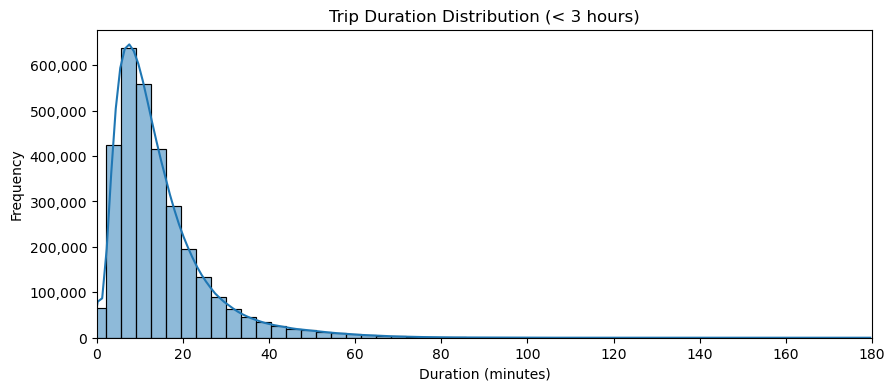

In [122]:
# Filter trips longer than 3 hours
df_filtered = df[df["trip_duration_min"] < 180]

plt.figure(figsize=(10, 4))
ax = sns.histplot(df_filtered["trip_duration_min"], bins=60, kde=True)
format_axis(ax)
plt.title("Trip Duration Distribution (< 3 hours)")
plt.xlim(0, 180)
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

### Hourly Trip Volume

This plot shows trip volume by hour across the month. It gives a rough view of usage patterns, including morning and evening peak



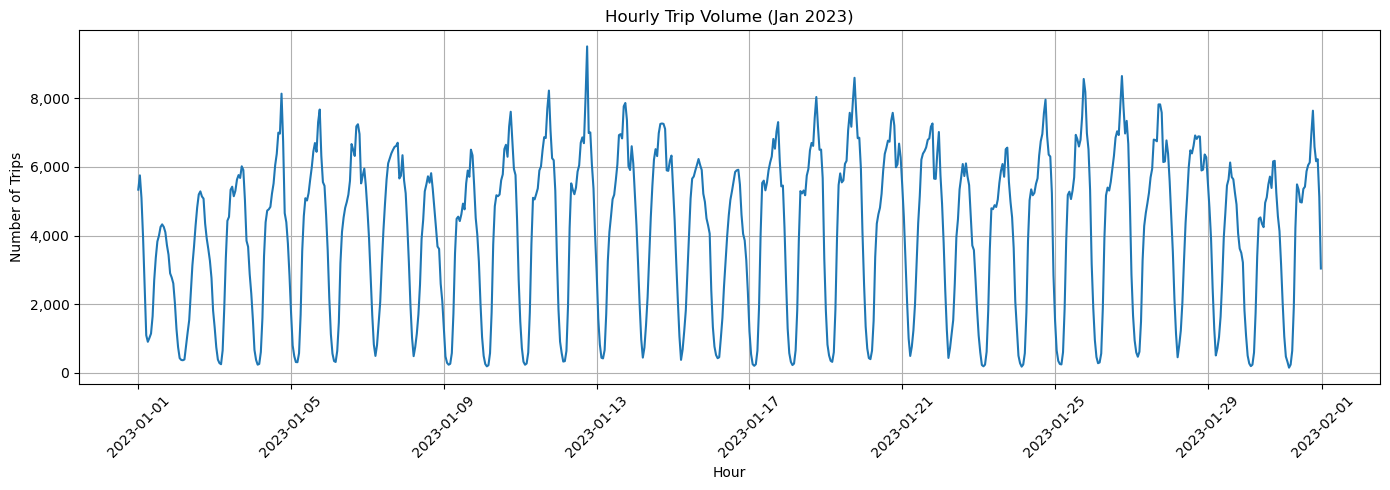

In [124]:
# Hours trip volume (based on pickup time)
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.floor("h")
trip_hourly = df.groupby("pickup_hour").size().reset_index(name="trip_count")

# Ensure the pickup_hour column is datetime type (for proper x-axis formatting)
trip_hourly["pickup_hour"] = pd.to_datetime(trip_hourly["pickup_hour"])

plt.figure(figsize=(14, 5))
ax = sns.lineplot(data=trip_hourly, x="pickup_hour", y="trip_count")
format_axis(ax)
plt.title("Hourly Trip Volume (Jan 2023)")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary

The dataset appears generally clean and well-structured after filtering. Some fields like `airport_fee` and `congestion_surcharge` contain minor structural missingness. Trip duration and distance show strong right-skewed distributions, while hourly trip volumes reveal consistent daily patterns.

Next step: transform key metrics into a summarized table for downstream visualization and storage.